In [1]:
import pandas as pd
import sc2ts
import tszip
import numpy as np
import matplotlib.pyplot as plt
import pathlib

In [2]:
datadir = pathlib.Path("../data")

In [3]:
def ts_summary(ts):
    return {"samples": ts.num_samples, "sites": ts.num_sites, "mutations": ts.num_mutations}

# Comparison of UShER and sc2ts on Viridian data

In [4]:
ts_usher_full = tszip.load(datadir/"usher_viridian_v1.0.trees.tsz")

In [5]:
ts_summary(ts_usher_full)

{'samples': 4471579, 'sites': 27508, 'mutations': 3364841}

Comparison with sc2ts is complicated because there's several versions. 

- The "base" ARG is the (almost) the raw output of sc2ts inference, with a few minor bits of postprocessing done
- The "final" ARG is the one that we release on Zenodo, which has deletions etc mapped on to it
- The "intersection" ARGs are then the ARGs that are most comparable between sc2ts and UShER.

In [6]:
ts_sc2ts_base = tszip.load("../arg_postprocessing/sc2ts_v1_2023-02-21_pr_pp.trees")
ts_summary(ts_sc2ts_base)

{'samples': 2482157, 'sites': 29803, 'mutations': 1906167}

In [7]:
ts_sc2ts_final = tszip.load(datadir / "sc2ts_viridian_v1.2.trees.tsz")

In [8]:
ts_summary(ts_sc2ts_final)

{'samples': 2482157, 'sites': 29893, 'mutations': 2285344}

In [10]:
ts_sc2ts_final.num_mutations - ts_sc2ts_base.num_mutations

379177

We have 379177 extra mutations as a result of the site remapping.

In [65]:
# https://gist.github.com/alimanfoo/c5977e87111abe8127453b21204c1065
def find_runs(x):
    """Find runs of consecutive items in an array."""
    
    # ensure array
    x = np.asanyarray(x)
    if x.ndim != 1:
        raise ValueError("only 1D array supported")
    n = x.shape[0]

    # handle empty array
    if n == 0:
        return np.array([]), np.array([]), np.array([])
    
    else:
        # find run starts
        loc_run_start = np.empty(n, dtype=bool)
        loc_run_start[0] = True
        np.not_equal(x[:-1], x[1:], out=loc_run_start[1:])
        run_starts = np.nonzero(loc_run_start)[0]

        # find run values
        run_values = x[loc_run_start]
        # find run lengths
        run_lengths = np.diff(np.append(run_starts, n))
        return run_values, run_starts, run_lengths


def add_genes_to_axis(ax):
    genes = sc2ts.get_gene_coordinates()
    mids = []
    for j, (gene, (left, right)) in enumerate(genes.items()):
        mids.append(left + (right - left) / 2)
        # FIXME totally arbitrary choice of colours, use something better!
        colour = "black"
        if j % 2 == 1:
            colour = "green"
        ax.axvspan(left, right, color=colour, alpha=0.1, zorder=0)

    ax2 = ax.secondary_xaxis("top")
    ax2.tick_params(axis="x")
    ax2.set_xticks(mids, minor=False)
    ax2.set_xticklabels(list(genes.keys()), rotation="vertical")


def plot_per_site_count(pos, count, annotate_threshold):
    fig, ax = plt.subplots(1, 1, figsize=(16, 4))
    ax.plot(pos, count)
    add_genes_to_axis(ax)
    threshold = np.max(count) * annotate_threshold

    # Show runs of sites exceeding threshold
    for v, start, length in zip(*find_runs(count > threshold)):
        if v:
            end = start + length
            x, y = int(pos[start]), int(pos[min(len(pos) - 1, end)])
            if x == y - 1:
                label = f"{x}"
            else:
                label = f"{x}-{y}"
            plt.annotate(label, xy=(x, count[start]), xycoords="data")
    ax.set_xlabel("Position on genome")
    return fig, ax


def plot_mutations_per_site(ts, annotate_threshold=0.9):
  
    count = np.bincount(ts.mutations_site, minlength=ts.num_sites)
    fig, ax = plot_per_site_count(ts.sites_position, count, annotate_threshold)
    zero_fraction = np.sum(count == 0) / ts.num_sites
    mean_per_site = np.mean(count)
    ax.annotate(
        f"{zero_fraction * 100:.2f}% sites have 0 mutations\n"
        f"{mean_per_site: .2f} mutations per site",
        xy=(ts.sites_position[0], np.max(count)),
        xycoords="data",
    )
    ax.set_ylabel("Number of mutations")


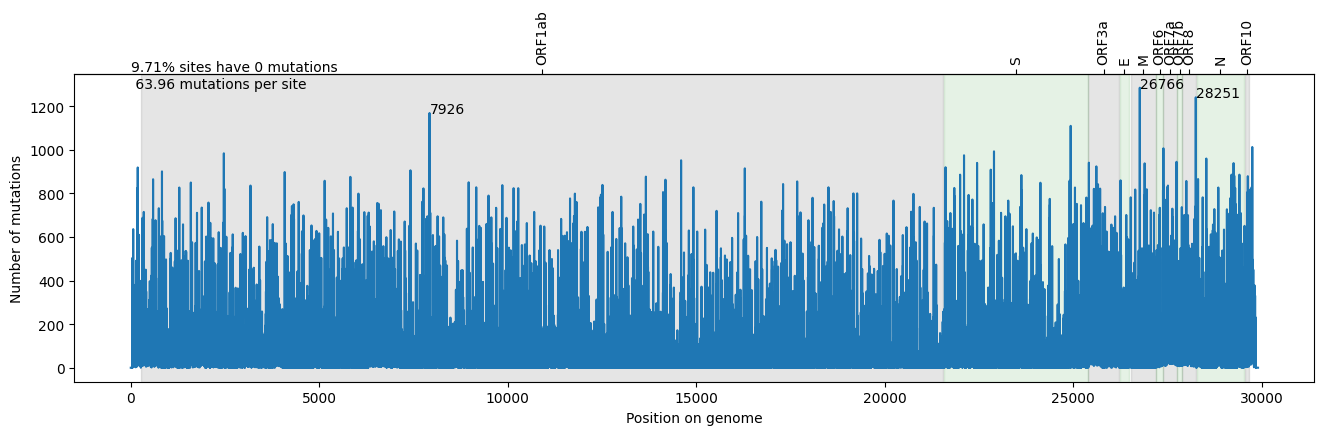

In [66]:
plot_mutations_per_site(ts_sc2ts_base)

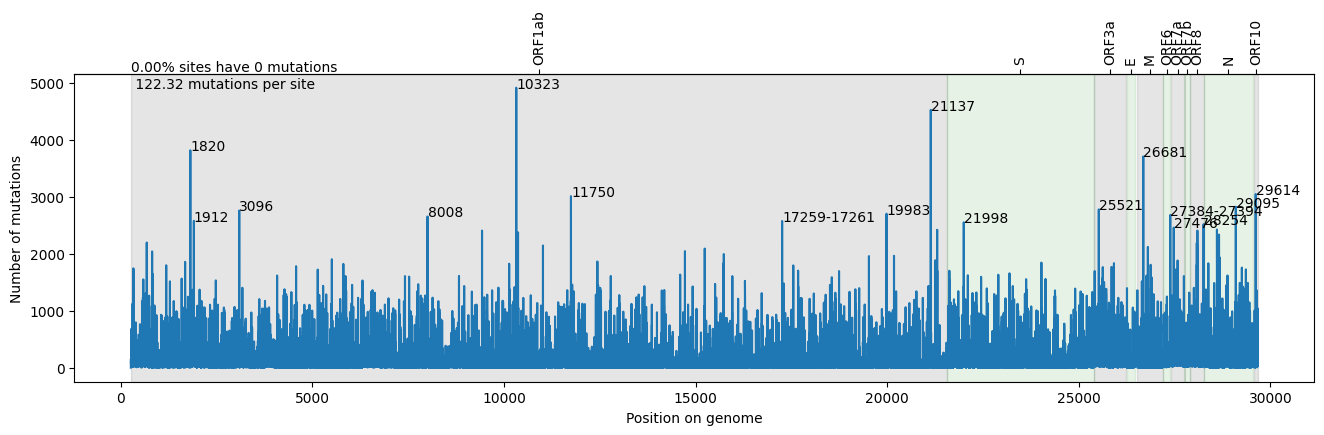

In [21]:
plot_mutations_per_site(ts_usher_full, annotate_threshold=0.5)

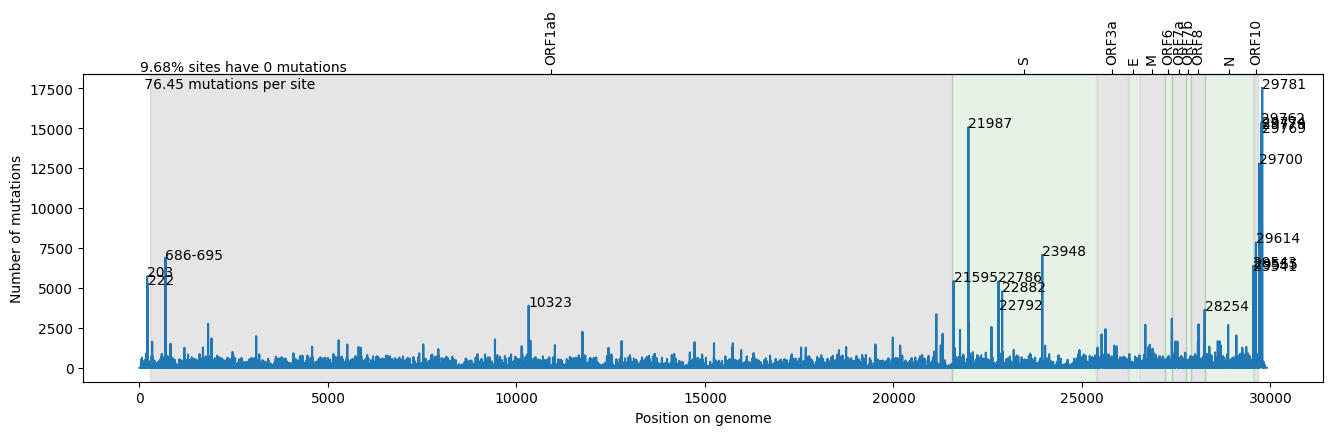

In [22]:
plot_mutations_per_site(ts_sc2ts_final, annotate_threshold=0.2)

These are all hard to compare. The sc2ts ARG is using a different set of sites, and when we've mapped back in deletions it's not easy to see how to compare these fairly.

So, we compute the intersection between the two ARGs, reporting on the subset of both for that share the same samples and sites.

# Intersection comparison

In [15]:
ts_sc2ts_inter = tszip.load(datadir / "sc2ts_viridian_inter_v1.2.trees.tsz")
ts_summary(ts_sc2ts_inter)

{'samples': 2475418, 'sites': 27507, 'mutations': 2078370}

In [16]:
ts_usher_inter = tszip.load(datadir / "usher_viridian_inter_v1.2.trees.tsz")
ts_summary(ts_usher_inter)

{'samples': 2475418, 'sites': 27507, 'mutations': 1934680}

In [96]:
ts_sc2ts_inter.num_mutations - ts_usher_inter.num_mutations

143690

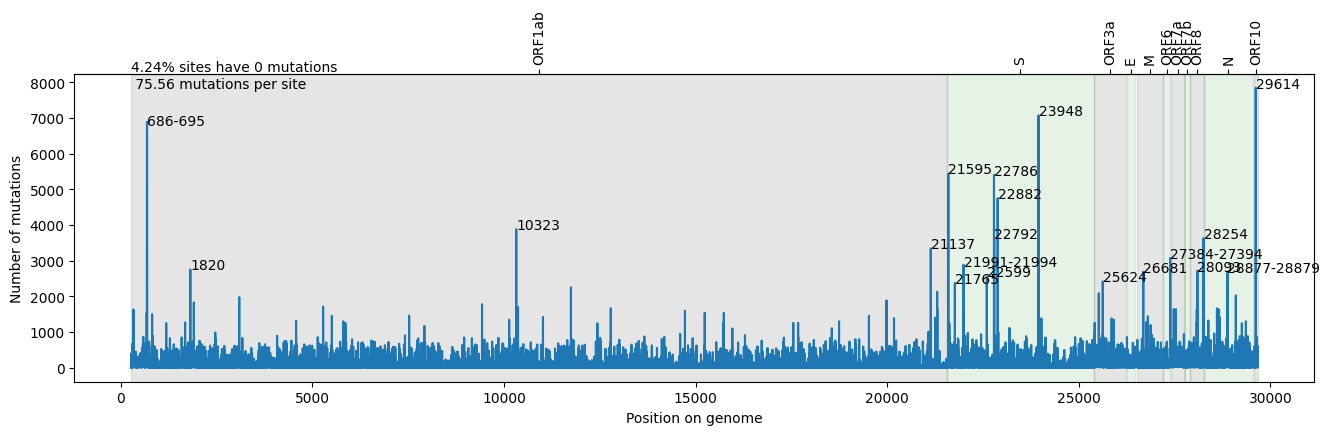

In [23]:
plot_mutations_per_site(ts_sc2ts_inter, annotate_threshold=0.3)

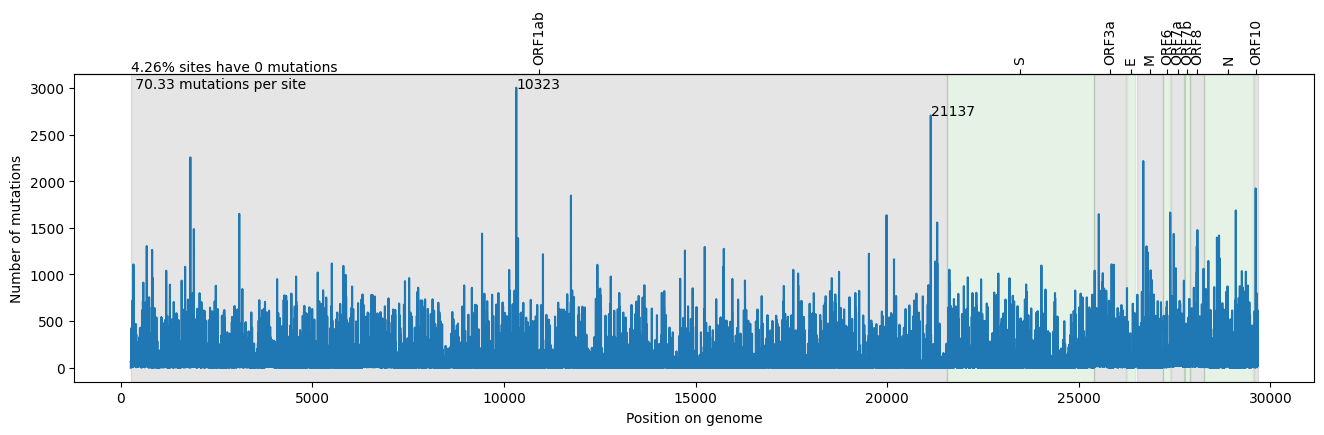

In [24]:
plot_mutations_per_site(ts_usher_inter, annotate_threshold=0.9)

In [25]:
dfm_sc2ts_inter = sc2ts.mutation_data(ts_sc2ts_inter, inheritance_stats=False)
dfm_sc2ts_inter

,mutation_id,position,parent,node,inherited_state,derived_state,date
0,0,269,-1,2721238,G,A,2020-12-16
1,1,269,-1,74546,G,A,2021-01-04
2,2,269,-1,97151,G,A,2021-01-27
3,3,269,-1,97236,G,A,2021-01-27
4,4,269,-1,114666,G,A,2021-02-12
...,...,...,...,...,...,...,...
2078365,2078365,29671,-1,1100325,A,G,2022-07-02
2078366,2078366,29671,-1,2497100,A,G,2022-07-08
2078367,2078367,29671,-1,1113651,A,G,2022-07-12
2078368,2078368,29671,-1,1167429,A,G,2022-09-10


In [26]:
dfm_usher_inter = sc2ts.mutation_data(ts_usher_inter, inheritance_stats=False)
dfm_usher_inter

,mutation_id,position,parent,node,inherited_state,derived_state
0,0,269,-1,2950593,G,A
1,1,269,-1,74546,G,A
2,2,269,-1,2941538,G,A
3,3,269,-1,2930168,G,A
4,4,269,-1,2810634,G,A
...,...,...,...,...,...,...
1934675,1934675,29671,-1,1050450,A,G
1934676,1934676,29671,-1,2716802,A,G
1934677,1934677,29671,-1,2844868,A,G
1934678,1934678,29671,-1,2718613,A,G


In [27]:
dfm_sc2ts_inter_indels = dfm_sc2ts_inter[
    (dfm_sc2ts_inter.inherited_state == "-") | (dfm_sc2ts_inter.derived_state == "-")]
dfm_sc2ts_inter_indels

,mutation_id,position,parent,node,inherited_state,derived_state,date
5251,5251,335,-1,9218,C,-,2020-05-01
5253,5253,335,-1,2736630,C,-,2020-05-08
5254,5254,335,-1,10030,C,-,2020-05-08
5255,5255,335,-1,10581,C,-,2020-05-13
5256,5256,335,-1,1237496,C,-,2020-05-13
...,...,...,...,...,...,...,...
2069473,2069473,29614,-1,1224709,C,-,2023-02-08
2069474,2069474,29614,-1,2475027,C,-,2023-02-09
2069476,2069476,29614,-1,1225298,C,-,2023-02-10
2069477,2069477,29614,-1,1225498,C,-,2023-02-10


In [28]:
ts_sc2ts_inter.num_mutations - ts_usher_inter.num_mutations - dfm_sc2ts_inter_indels.shape[0]

46371

In [29]:
(ts_sc2ts_inter.num_mutations - ts_usher_inter.num_mutations - dfm_sc2ts_inter_indels.shape[0]) / ts_usher_inter.num_mutations

0.02396830483594186

If we exclude all indel mutations from the sc2ts ARG we have 2.3% more mutations than UShER.

In [30]:
dfm_sc2ts_inter_indels["position"].value_counts()

position
692      6784
689      6783
690      6782
688      6779
687      6778
         ... 
18744       1
14724       1
22792       1
22786       1
22882       1
Name: count, Length: 108, dtype: int64

In [31]:
df_remapped_sites = pd.read_csv("../arg_postprocessing/sc2ts_v1_2023-02-21_pr_pp_sites_to_remap.csv")
df_remapped_sites

,position,reason
0,203,pango
1,222,pango
2,335,pango
3,337,pango
4,683,pango
...,...,...
158,29762,pango
159,29769,pango
160,29774,pango
161,29779,pango


In [32]:
del_sites = df_remapped_sites[df_remapped_sites["reason"] == "deletion"]["position"].values
del_sites

array([  686,   687,   688,   689,   690,   691,   692,   693,   694,
        6513,  6514,  6515, 11283, 11284, 11285, 11286, 11287, 11288,
       11289, 11290, 11291, 11292, 11293, 11294, 11295, 11296, 21633,
       21634, 21635, 21636, 21637, 21638, 21639, 21640, 21641, 21765,
       21766, 21767, 21768, 21769, 21770, 21987, 21988, 21989, 21990,
       21991, 21992, 21993, 21994, 21995, 22029, 22030, 22031, 22032,
       22033, 22034, 22194, 22195, 22196, 28248, 28249, 28250, 28251,
       28252, 28253, 28271, 28362, 28363, 28364, 28365, 28366, 28367,
       28368, 28369, 28370])

In [33]:
del_sites.shape

(75,)

In [34]:
dfm_usher_inter_no_del_sites = dfm_usher_inter[~dfm_usher_inter["position"].isin(del_sites)]
dfm_usher_inter_no_del_sites

,mutation_id,position,parent,node,inherited_state,derived_state
0,0,269,-1,2950593,G,A
1,1,269,-1,74546,G,A
2,2,269,-1,2941538,G,A
3,3,269,-1,2930168,G,A
4,4,269,-1,2810634,G,A
...,...,...,...,...,...,...
1934675,1934675,29671,-1,1050450,A,G
1934676,1934676,29671,-1,2716802,A,G
1934677,1934677,29671,-1,2844868,A,G
1934678,1934678,29671,-1,2718613,A,G


In [35]:
dfm_sc2ts_inter_no_del_sites = dfm_sc2ts_inter[~dfm_sc2ts_inter["position"].isin(del_sites)]
dfm_sc2ts_inter_no_del_sites

,mutation_id,position,parent,node,inherited_state,derived_state,date
0,0,269,-1,2721238,G,A,2020-12-16
1,1,269,-1,74546,G,A,2021-01-04
2,2,269,-1,97151,G,A,2021-01-27
3,3,269,-1,97236,G,A,2021-01-27
4,4,269,-1,114666,G,A,2021-02-12
...,...,...,...,...,...,...,...
2078365,2078365,29671,-1,1100325,A,G,2022-07-02
2078366,2078366,29671,-1,2497100,A,G,2022-07-08
2078367,2078367,29671,-1,1113651,A,G,2022-07-12
2078368,2078368,29671,-1,1167429,A,G,2022-09-10


In [36]:
dfm_sc2ts_inter_no_del_sites.shape[0] - dfm_usher_inter_no_del_sites.shape[0] 

57788

In [37]:
(dfm_sc2ts_inter_no_del_sites.shape[0] - dfm_usher_inter_no_del_sites.shape[0]) / dfm_usher_inter_no_del_sites.shape[0]

0.029988474354270638

If we exclude all sites that were remapped for deletions, we have 3% more mutations than UShER.

In [38]:
dfm_usher_inter_no_remapped_sites = dfm_usher_inter[~dfm_usher_inter["position"].isin(df_remapped_sites["position"])]
dfm_usher_inter_no_remapped_sites

,mutation_id,position,parent,node,inherited_state,derived_state
0,0,269,-1,2950593,G,A
1,1,269,-1,74546,G,A
2,2,269,-1,2941538,G,A
3,3,269,-1,2930168,G,A
4,4,269,-1,2810634,G,A
...,...,...,...,...,...,...
1934675,1934675,29671,-1,1050450,A,G
1934676,1934676,29671,-1,2716802,A,G
1934677,1934677,29671,-1,2844868,A,G
1934678,1934678,29671,-1,2718613,A,G


In [39]:
dfm_sc2ts_inter_no_remapped_sites = dfm_sc2ts_inter[~dfm_sc2ts_inter["position"].isin(df_remapped_sites["position"])]
dfm_sc2ts_inter_no_remapped_sites

,mutation_id,position,parent,node,inherited_state,derived_state,date
0,0,269,-1,2721238,G,A,2020-12-16
1,1,269,-1,74546,G,A,2021-01-04
2,2,269,-1,97151,G,A,2021-01-27
3,3,269,-1,97236,G,A,2021-01-27
4,4,269,-1,114666,G,A,2021-02-12
...,...,...,...,...,...,...,...
2078365,2078365,29671,-1,1100325,A,G,2022-07-02
2078366,2078366,29671,-1,2497100,A,G,2022-07-08
2078367,2078367,29671,-1,1113651,A,G,2022-07-12
2078368,2078368,29671,-1,1167429,A,G,2022-09-10


In [40]:
dfm_usher_inter_no_remapped_sites.shape[0] - dfm_sc2ts_inter_no_remapped_sites.shape[0]

4785

In [41]:
(dfm_usher_inter_no_remapped_sites.shape[0] - dfm_sc2ts_inter_no_remapped_sites.shape[0]) / dfm_usher_inter_no_remapped_sites.shape[0]

0.002606977328286821

In [42]:
dfm_usher_inter_no_remapped_sites["position"].unique().shape

(26192,)

If we restrict to the 26192 sites that were not remapped, sc2ts has 4785 (0.26%) fewer mutations than UShER.

In [97]:
dfm_sc2ts_inter_remapped_sites = dfm_sc2ts_inter[dfm_sc2ts_inter["position"].isin(df_remapped_sites["position"])]
dfm_sc2ts_inter_remapped_sites

,mutation_id,position,parent,node,inherited_state,derived_state,date
5246,5246,335,-1,2738712,C,T,2020-03-11
5247,5247,335,-1,1228490,C,T,2020-03-25
5248,5248,335,-1,3124,C,T,2020-03-30
5249,5249,335,-1,3214,C,T,2020-03-31
5250,5250,335,-1,5345,C,T,2020-04-09
...,...,...,...,...,...,...,...
2069476,2069476,29614,-1,1225298,C,-,2023-02-10
2069477,2069477,29614,-1,1225498,C,-,2023-02-10
2069478,2069478,29614,-1,1225723,C,-,2023-02-11
2069479,2069479,29614,-1,1225790,C,T,2023-02-12


In [44]:
dfm_usher_inter_remapped_sites = dfm_usher_inter[dfm_usher_inter["position"].isin(df_remapped_sites["position"])]
dfm_usher_inter_remapped_sites

,mutation_id,position,parent,node,inherited_state,derived_state
5457,5457,335,-1,2970679,C,T
5458,5458,335,-1,2858079,C,T
5459,5459,335,-1,1228490,C,T
5460,5460,335,-1,3214,C,T
5461,5461,335,-1,5345,C,T
...,...,...,...,...,...,...
1926466,1926466,29614,-1,1221375,C,T
1926467,1926467,29614,-1,1224289,C,T
1926468,1926468,29614,-1,2709041,C,T
1926469,1926469,29614,-1,1225100,C,T


In [45]:
dfm_sc2ts_inter_remapped_sites.shape[0] / dfm_usher_inter_remapped_sites.shape[0] 

2.4964070106126726

When we consider just the 163 sites that have been remapped, sc2ts has around 2.5 times more mutations than UShER (247696 vs 99221).

## Indels in non-deletion sites

What about indels that occur on the sites that we remapped because they are pango informative? There are some, but it's only 10K mutations and unlike to be significant overall. 

We could remap these sites by masking deletions to make this a closer comparison, but it's probably not worth the trouble.

In [46]:
indels = (dfm_sc2ts_inter_no_del_sites.inherited_state == "-") | (dfm_sc2ts_inter_no_del_sites.derived_state == "-")
dfm_sc2ts_inter_no_del_sites[indels]

,mutation_id,position,parent,node,inherited_state,derived_state,date
5251,5251,335,-1,9218,C,-,2020-05-01
5253,5253,335,-1,2736630,C,-,2020-05-08
5254,5254,335,-1,10030,C,-,2020-05-08
5255,5255,335,-1,10581,C,-,2020-05-13
5256,5256,335,-1,1237496,C,-,2020-05-13
...,...,...,...,...,...,...,...
2069473,2069473,29614,-1,1224709,C,-,2023-02-08
2069474,2069474,29614,-1,2475027,C,-,2023-02-09
2069476,2069476,29614,-1,1225298,C,-,2023-02-10
2069477,2069477,29614,-1,1225498,C,-,2023-02-10


# All sites parsimony analysis

Another way we can measure the parsimony of the two different intersection ARGs is to see how parsimonious they are when we map back mutations at *all* sites along the genome. The dataframes below count the number of mutations that were in the ARG at that position before remapping ("old"), the number of mutations after remapping ("new"), and the intersection between the old and new sets of mutations. If the ARG is a good representation of the data, we would expect the sets of mutations before and after parsimony remapping to be basically the same.

This analysis is partially done as an automatic output of the postprocessing pipeline [here](
https://github.com/jeromekelleher/sc2ts-paper/blob/main/arg_postprocessing/logs/usher_sc2ts_comparison.ipynb)

**NOTE** we may have an off-by-one error here in the "new" column, as we report 1 mutation in the flanks, but this seems unlikely if all the sequences carry the reference base?



In [54]:
df_usher_asp = pd.read_csv("../arg_postprocessing/usher_2023-02-21_intersection_asp.csv", index_col=0).set_index("site")
df_usher_asp

,old,new,intersection
site,,,
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0
5,0,1,0
...,...,...,...
29899,0,1,0
29900,0,1,0
29901,0,1,0


In [55]:
df_sc2ts_asp = pd.read_csv("../arg_postprocessing/sc2ts_2023-02-21_intersection_asp.csv", index_col=0).set_index("site")
df_sc2ts_asp

,old,new,intersection
site,,,
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0
5,0,1,0
...,...,...,...
29899,0,1,0
29900,0,1,0
29901,0,1,0


In [56]:
df_usher_asp.sum()

old              1934679
new             11470551
intersection     1927275
dtype: int64

In [57]:
df_sc2ts_asp.sum()

old              2078370
new             10840687
intersection     2072695
dtype: int64

In [62]:
df_usher_asp["new"].sum() - df_sc2ts_asp["new"].sum()

np.int64(629864)

In [63]:
_ / df_usher_asp["new"].sum() 

np.float64(0.05491139876366881)

So, while the UShER tree has fewer mutations when we consider the intersection sites, when we remap *all* sites in the ARG, and take deletions into account, the sc2ts ARG has 629864 (5.5%) fewer mutations

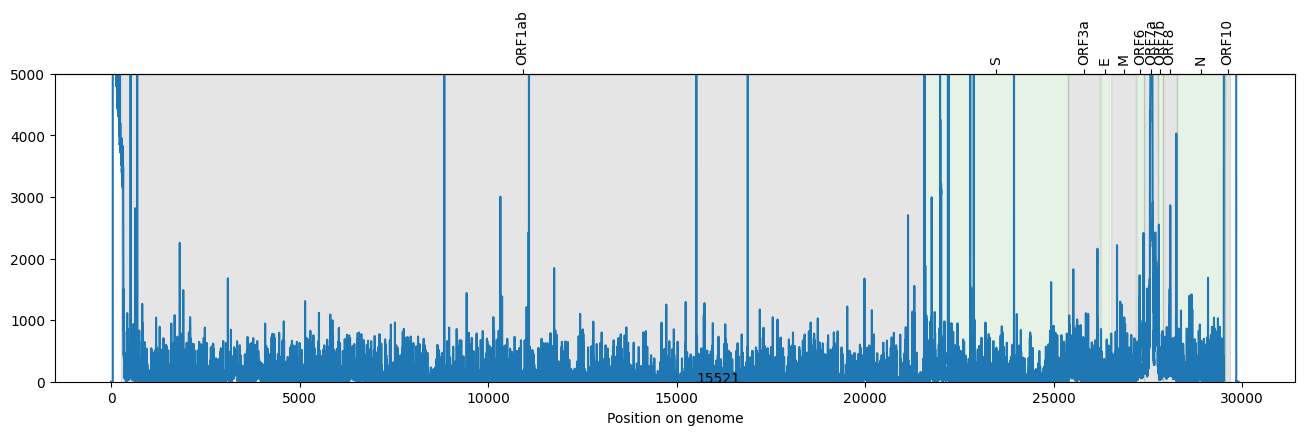

In [76]:
_, ax = plot_per_site_count(df_sc2ts_asp.index, df_usher_asp["new"], 0.9)
ax.set_ylim(0, 5000);

In [82]:
df_usher_asp[df_usher_asp["new"] > 50_000]

,old,new,intersection
site,,,
47,0,52297,0
51,0,52980,0
52,0,52818,0
53,0,52684,0
54,0,52619,0
8835,0,147738,0
15521,0,274478,0
29828,0,57737,0
29829,0,59154,0


Two very large outlier sites that were not included in the original UShER or sc2ts sites, 8835 and 15521 have large mutation counts for both (with UShER having significantly fewer).

In [83]:
df_sc2ts_asp.loc[[8835, 15521]]

,old,new,intersection
site,,,
8835,0,179776,0
15521,0,324457,0


In [84]:
df_usher_asp.loc[[8835, 15521]]

,old,new,intersection
site,,,
8835,0,147738,0
15521,0,274478,0


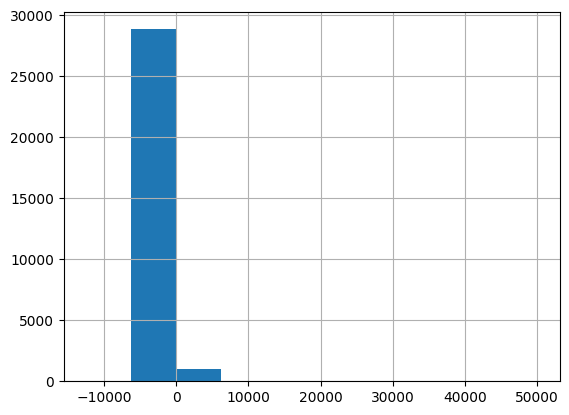

In [88]:
diff = df_sc2ts_asp.new - df_usher_asp.new
diff.hist();

The difference seems mostly negative (sc2ts smaller) with a few large positive outliers (UShER smaller). 

In [89]:
diff[diff > 20_000]

site
8835     32038
15521    49979
Name: new, dtype: int64

This is from the large outlier sites above, 88365 and 15521 (UShER definitely seems to be doing a better job around these locations). If we exclude those and focus on smaller differences, we get 

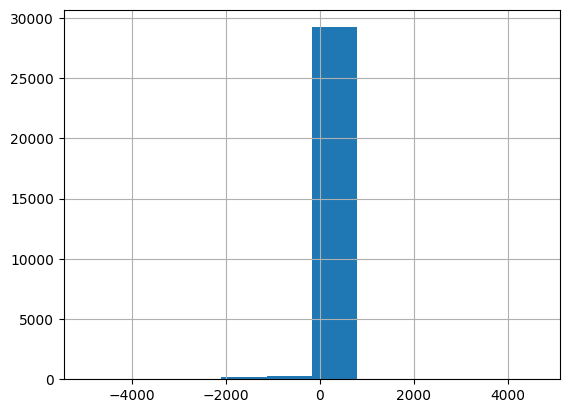

In [92]:
diff[diff.abs() < 5_000].hist();

In [95]:
diff[diff < -1_000]

site
686     -3428
687     -3429
688     -3423
689     -3428
690     -3430
         ... 
29831   -3536
29833   -1048
29834   -1054
29835   -1136
29836   -1129
Name: new, Length: 309, dtype: int64

The locations where sc2ts does significantly better are in the regions that were remapped for deletions. Thus, it's likely that the difference in overall parsimony is attributable to the inclusion of the signals from deletions in the sc2ts ARG and the additional parsimony hueristics that were applied.